**Table of contents**<a id='toc0_'></a>    
- [Titanic survivor prediction](#toc1_)    
  - [Loading the dataset](#toc1_1_)    
  - [Data exploration](#toc1_2_)    
    - [Null values](#toc1_2_1_)    
    - [How each column correlates with survivability](#toc1_2_2_)    
  - [Data preprocessing](#toc1_3_)    
    - [Age groups](#toc1_3_1_)    
    - [One Hot Encoding](#toc1_3_2_)    
    - [Final adjust](#toc1_3_3_)    
    - [Final function](#toc1_3_4_)    
  - [Model](#toc1_4_)    
  - [Tree classifier](#toc1_5_)    
  - [Final evaluation](#toc1_6_)    
  - [Different imputations for missing age](#toc1_7_)    
    - [Mean](#toc1_7_1_)    
    - [Model prediction](#toc1_7_2_)    
    - [Classify by age](#toc1_7_3_)    
  - [Submission](#toc1_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Titanic survivor prediction](#toc0_)
This notebook contains my solution to the most famous problem on Kaggle: predicting which passengers survived the titanic disaster

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

## <a id='toc1_1_'></a>[Loading the dataset](#toc0_)

In [2]:
raw_titanic_data = pd.read_csv('data/titanic/train.csv', index_col='PassengerId')
raw_titanic_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# we are going to use the raw data later
titanic_data = raw_titanic_data.copy()

In [4]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


## <a id='toc1_2_'></a>[Data exploration](#toc0_)

First, let's see if the data is valid. Since thete are only 11 columns, we can check them individually

In [5]:
def plot_counts(df, column):
    """Plot the value counts for a column in a dataframe
    """
    df[column].value_counts().plot(kind='bar')
    plt.xlabel(column)
    plt.ylabel('Count')

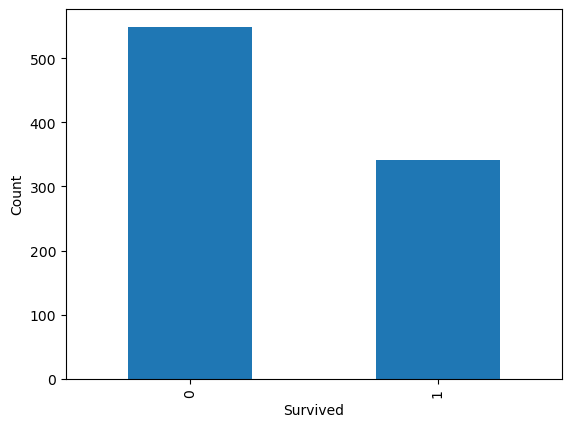

In [6]:
plot_counts(titanic_data, 'Survived')

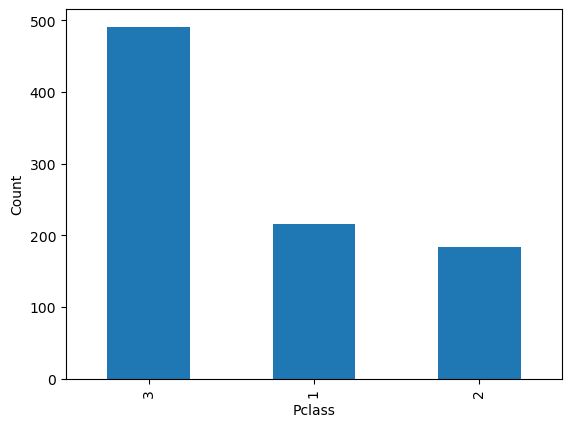

In [7]:
plot_counts(titanic_data, 'Pclass')

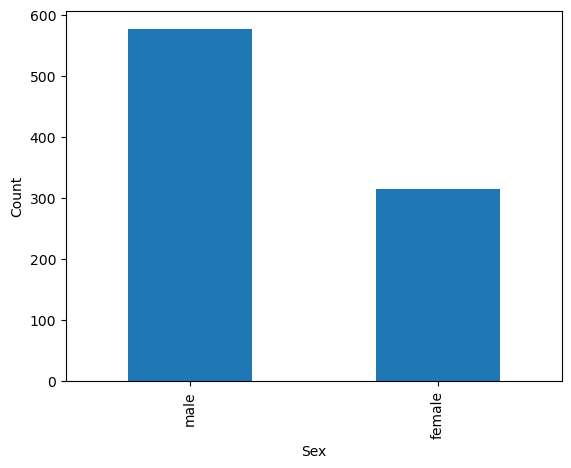

In [8]:
plot_counts(titanic_data, 'Sex')

In [9]:
titanic_data[['Age', 'SibSp', 'Parch', 'Fare']].describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


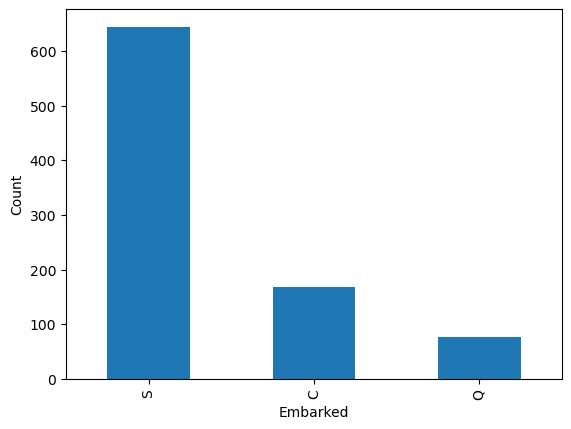

In [10]:
plot_counts(titanic_data, 'Embarked')

The values are all valid. We are going to check the null values

### <a id='toc1_2_1_'></a>[Null values](#toc0_)

In [11]:
titanic_data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

The null values are in Age, Cabin and Embarked. Let's check

In [12]:
titanic_data[titanic_data['Age'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...
860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S


In [13]:
titanic_data[titanic_data['Embarked'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [14]:
titanic_data[~titanic_data['Cabin'].isna()].head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C


Cabin has so many null values, and at first seems to have no relation with the other info. We are going to ignore this column.

Age is a important column with many null values. We will try different imputations for this one. At first, we are going to impute the mean age.

Embarked has only two missing values, so let's just fill these with the mode

In [15]:
# filling the embarked with mode
emb_mode = titanic_data['Embarked'].mode()[0]
titanic_data['Embarked'] = titanic_data['Embarked'].fillna(emb_mode)

# filling the age with mean
age_mean = titanic_data['Age'].mean()
titanic_data['Age'] = titanic_data['Age'].fillna(age_mean)

# cabin drop
titanic_data = titanic_data.drop(columns=['Cabin'])

### <a id='toc1_2_2_'></a>[How each column correlates with survivability](#toc0_)

In [36]:
def plot_survived_by_column(titanic_data, column):
    """Plot how many survived on side of the total for a categorical column
    """
    
    group = titanic_data.groupby(column)
    ind = np.arange(len(group))
    width = 0.35

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.bar(ind, group['Survived'].count(), width, label='Total')
    ax.bar(ind+width, group['Survived'].sum(), width, label='Survived')

    

    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(group['Survived'].count().index)
    ax.legend()
    ax.set_ylabel('Count')
    ax.set_xlabel(column)

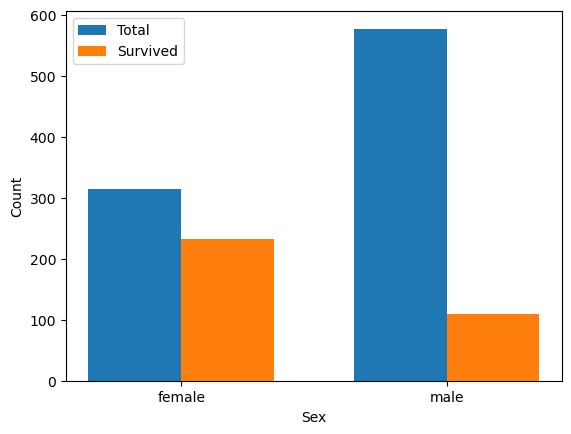

In [37]:
plot_survived_by_column(titanic_data, 'Sex')

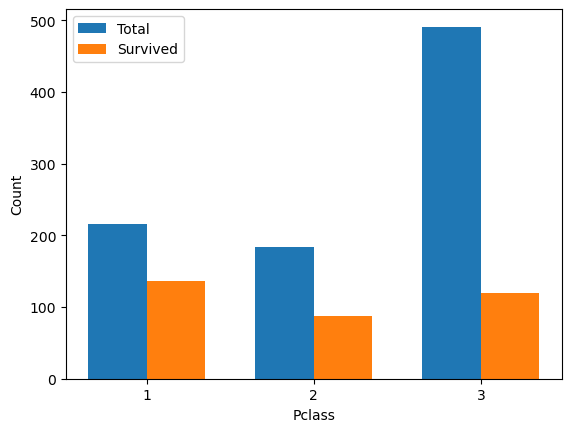

In [38]:
plot_survived_by_column(titanic_data, 'Pclass')

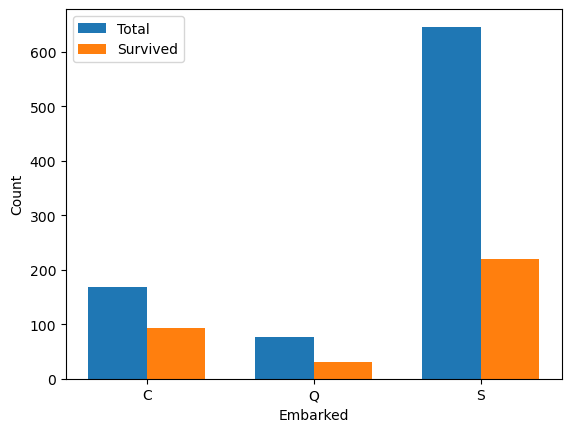

In [39]:
plot_survived_by_column(titanic_data, 'Embarked')

In [73]:
def percentages_of_survivability(titanic_data, column):
    """Return the percentage of survivability for each value in a column"""
    survival = titanic_data.groupby(column)['Survived'].agg(['count', 'sum'])
    survival = survival.rename(columns={'sum': 'Survived', 'count': 'Total'})
    survival['Survivability [%]'] = survival['Survived'] / survival['Total'] * 100
    return survival

In [74]:
# since this one is not so clear by the graph, lets calculate the percentage
# of survivability for each
percentages_of_survivability(titanic_data, 'Embarked')

,Total,Survived,Survivability [%]
Embarked,,,
C,168,93,55.357143
Q,77,30,38.961039
S,646,219,33.900929


What we can see
- Sex: Female has a lot more chance of survival. Makes sense because the rule for the life boats give a preference for them
- Pclass: the higher the class of the ticket, higher the chance of survival, as expected, because richer people are in the higher cabins.
- Embarked: Seems to make a difference, but it's not clear why. Maybe a correlation for the port with other data.

Text(0, 0.5, 'Fare')

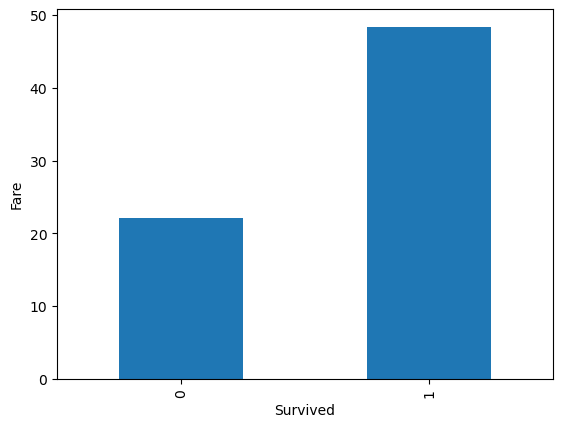

In [75]:
titanic_data.groupby('Survived').Fare.mean().plot(kind='bar')
plt.ylabel('Fare')

The passengers with higher fare had a grater chance of surviving

In [76]:
percentages_of_survivability(titanic_data, 'SibSp')

,Total,Survived,Survivability [%]
SibSp,,,
0,608,210,34.539474
1,209,112,53.588517
2,28,13,46.428571
3,16,4,25.000000
4,18,3,16.666667
5,5,0,0.000000
8,7,0,0.000000


In [77]:
percentages_of_survivability(titanic_data, 'Parch')

,Total,Survived,Survivability [%]
Parch,,,
0,678,233,34.365782
1,118,65,55.084746
2,80,40,50.000000
3,5,3,60.000000
4,4,0,0.000000
5,5,1,20.000000
6,1,0,0.000000


We can see that having a sibling, spouse or parent seems to increase the chance of surviving. If the quantity matters, it's hard to know since for values higher than two we have only few samples, but seems that having a greater number seems to reduce the chance. For the SibSp for example, where it is higher than 3 the survivability goes very low

## <a id='toc1_3_'></a>[Data preprocessing](#toc0_)

### <a id='toc1_3_1_'></a>[Age groups](#toc0_)

We will do some feature engenerring on the age column, to group people into age classes, since the young had preference to go on the life boats.

In [78]:
def create_age_group(titanic_data, minage, maxage, name, enc):
    titanic_data.loc[(titanic_data['Age'] >= minage) & (titanic_data['Age'] < maxage), 'AgeGroup'] = name
    titanic_data.loc[(titanic_data['Age'] >= minage) & (titanic_data['Age'] < maxage), 'AgeGroupEn'] = enc

    
def groups_of_age(titanic_data):
    """Create groups based on the age, from Child to Elder.
    Generates a categorical column and a encoded column"""
    
    titanic_data['AgeGroup'] = None
    titanic_data['AgeGroupEn'] = 0
    
    groups = [
        [0, 9, 'Child', 0],
        [9, 18, 'Teen', 1],
        [18, 30, 'Young', 2],
        [30, 60, 'Adult', 3],
        [60, 81, 'Elder', 4]
    ]

    for minage, maxage, name, enc in groups:
        create_age_group(titanic_data, minage, maxage, name, enc)
        
    return titanic_data


In [79]:
titanic_data = groups_of_age(titanic_data)

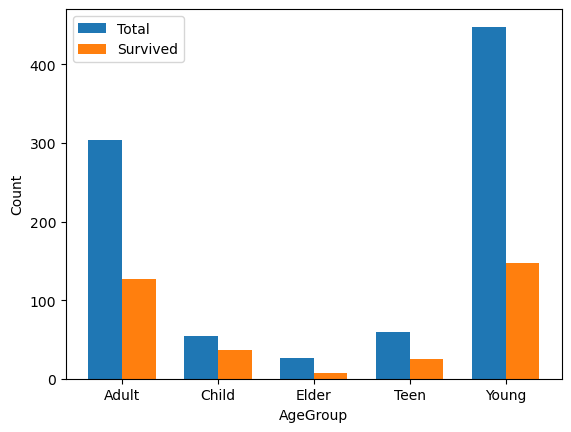

In [80]:
plot_survived_by_column(titanic_data, 'AgeGroup')

In [81]:
print('Percentages of survivability')
embarked_survival = titanic_data.groupby('AgeGroup')['Survived'].agg(['count', 'sum'])
(embarked_survival['sum'] / embarked_survival['count'] * 100).sort_values(ascending=False)

Percentages of survivability


AgeGroup
Child    66.666667
Teen     42.372881
Adult    41.776316
Young    32.812500
Elder    26.923077
dtype: float64

As expected, the child has the greater survivability, since they had preference to go on the life boats. The elder had the smaller chance of survival, probably because the lack of preferrence and difficulties to get to the life boats.

### <a id='toc1_3_2_'></a>[One Hot Encoding](#toc0_)
One hot encoding the categorical columns to put in the model

In [83]:
titanic_data = pd.get_dummies(titanic_data, columns=['Sex', 'Embarked'], drop_first=True)

### <a id='toc1_3_3_'></a>[Final adjust](#toc0_)
Let's do a final adjustement to our data by dropping the unecessary columns

In [85]:
titanic_data.drop(columns=['Name', 'Ticket', 'AgeGroup'])

,Survived,Pclass,Age,SibSp,Parch,Fare,AgeGroupEn,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0,3,22.000000,1,0,7.2500,2,1,0,1
2,1,1,38.000000,1,0,71.2833,3,0,0,0
3,1,3,26.000000,0,0,7.9250,2,0,0,1
4,1,1,35.000000,1,0,53.1000,3,0,0,1
5,0,3,35.000000,0,0,8.0500,3,1,0,1
...,...,...,...,...,...,...,...,...,...,...
887,0,2,27.000000,0,0,13.0000,2,1,0,1
888,1,1,19.000000,0,0,30.0000,2,0,0,1
889,0,3,29.699118,1,2,23.4500,2,0,0,1


### <a id='toc1_3_4_'></a>[Final function](#toc0_)
Build a function that does all the treatment nedded


In [95]:
def data_process(raw_titanic_data):
    
    titanic_data = raw_titanic_data
    
    # filling the embarked with mode
    emb_mode = titanic_data['Embarked'].mode()[0]
    titanic_data['Embarked'] = titanic_data['Embarked'].fillna(emb_mode)

    # filling the age with mean
    age_mean = titanic_data['Age'].mean()
    titanic_data['Age'] = titanic_data['Age'].fillna(age_mean)

    # cabin drop
    titanic_data = titanic_data.drop(columns=['Cabin'])
    
    titanic_data = groups_of_age(titanic_data)
    
    titanic_data = pd.get_dummies(titanic_data, columns=['Sex', 'Embarked'], drop_first=True)
    
    titanic_data = titanic_data.drop(columns=['Name', 'Ticket', 'AgeGroup'])
    
    return titanic_data

In [96]:
data_process(raw_titanic_data)

,Survived,Pclass,Age,SibSp,Parch,Fare,AgeGroupEn,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0,3,22.000000,1,0,7.2500,2,1,0,1
2,1,1,38.000000,1,0,71.2833,3,0,0,0
3,1,3,26.000000,0,0,7.9250,2,0,0,1
4,1,1,35.000000,1,0,53.1000,3,0,0,1
5,0,3,35.000000,0,0,8.0500,3,1,0,1
...,...,...,...,...,...,...,...,...,...,...
887,0,2,27.000000,0,0,13.0000,2,1,0,1
888,1,1,19.000000,0,0,30.0000,2,0,0,1
889,0,3,29.699118,1,2,23.4500,2,0,0,1


## <a id='toc1_4_'></a>[Model](#toc0_)

In [ ]:
titanic_data.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Age missing', 'SexEn', 'C', 'Q', 'S',
       'AgeGroup', 'AgeGroupEn'],
      dtype='object')

In [ ]:
selected_features = ['Pclass', 'SibSp', 'Parch',
       'Fare', 'Age missing', 'SexEn', 'C', 'Q', 'S',
       'Age']

In [ ]:
X = titanic_data[selected_features]
y = titanic_data['Survived']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, titanic_data['Survived'].values, test_size=0.2, random_state=7
)
print(X_train.shape)
print(X_test.shape)

(712, 10)
(179, 10)


## <a id='toc1_5_'></a>[Tree classifier](#toc0_)

## <a id='toc1_6_'></a>[Final evaluation](#toc0_)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
final_model = RandomForestClassifier(
    max_depth = 6, n_estimators=1000, random_state=7, bootstrap=False, criterion='entropy'
)



In [ ]:
final_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=6,
                       n_estimators=1000, random_state=7)

In [ ]:
from sklearn.metrics import accuracy_score
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_test_pred))

Train accuracy 0.8806179775280899
Test accuracy 0.776536312849162


In [ ]:
feat_imp_df = pd.DataFrame({
    'Feature name': selected_features,
    'Importance': final_model.feature_importances_
})
feat_imp_df.sort_values('Importance', ascending=False)

,Feature name,Importance
5,SexEn,0.466861
3,Fare,0.169996
9,Age,0.117810
0,Pclass,0.109861
1,SibSp,0.058035
2,Parch,0.027554
6,C,0.018609
8,S,0.016721
7,Q,0.007315
4,Age missing,0.007236


A lot of overfitting

## <a id='toc1_7_'></a>[Different imputations for missing age](#toc0_)

### <a id='toc1_7_1_'></a>[Mean](#toc0_)

### <a id='toc1_7_2_'></a>[Model prediction](#toc0_)

In [ ]:
titanic_data_age = titanic_data.loc[~titanic_data['Age'].isna()].copy()
titanic_data_age

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age missing,SexEn,C,Q,S,AgeGroup,AgeGroupEn
PassengerId,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,False,0,0,0,1,Young,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,False,1,1,0,0,Adult,3
3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,False,1,0,0,1,Young,2
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,False,1,0,0,1,Adult,3
5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,False,0,0,0,1,Adult,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,False,0,0,0,1,Young,2
888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,False,1,0,0,1,Young,2
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S,True,1,0,0,1,Young,2


In [ ]:
selected_features_age = ['Pclass', 'SibSp', 'Parch',
       'Fare', 'SexEn', 'C', 'Q', 'S']

In [ ]:
X_train_age, X_test_age, y_train_age, y_test_age = \
    train_test_split(
        titanic_data_age[selected_features_age].values, titanic_data_age['Age'].values,
        test_size=0.2, random_state=7
)

In [ ]:
rf_age_params = {'max_depth': range(1, 10)}

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_age = RandomForestRegressor(n_estimators=500)

In [ ]:
from sklearn.model_selection import GridSearchCV

cv_rf_impute = GridSearchCV(rf_age, param_grid=rf_age_params, scoring='neg_mean_absolute_error', refit=True,
                            n_jobs=-1, cv=4, verbose=2, error_score=np.nan, return_train_score=True)

In [ ]:
cv_rf_impute.fit(X_train_age, y_train_age)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


GridSearchCV(cv=4, estimator=RandomForestRegressor(n_estimators=500), n_jobs=-1,
             param_grid={'max_depth': range(1, 10)}, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
cv_rf_impute.best_params_

{'max_depth': 6}

In [ ]:
cv_rf_impute.best_score_

-8.242771329042489

In [ ]:
rf_age = RandomForestRegressor(n_estimators=500, max_depth=6, random_state=7)

In [ ]:
rf_age.fit(X_train_age, y_train_age)

RandomForestRegressor(max_depth=6, n_estimators=500, random_state=7)

In [ ]:
y_test_age_pred = rf_age.predict(X_test_age)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test_age, y_test_age_pred)

8.815667581775434

In [ ]:
y_pred_by_mean = np.repeat(titanic_data_age['Age'].mean(), len(y_test_age)).reshape(-1, 1)
y_pred_by_mean[0:3]

array([[29.69911765],
       [29.69911765],
       [29.69911765]])

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test_age, y_pred_by_mean)

9.387578047978968

There is litte improvement. Let's see in the model

In [ ]:
titanic_data['Age missing'].value_counts()

False    714
True     177
Name: Age missing, dtype: int64

In [ ]:
input_age = titanic_data.loc[titanic_data['Age missing'], selected_features_age]

<Axes: >

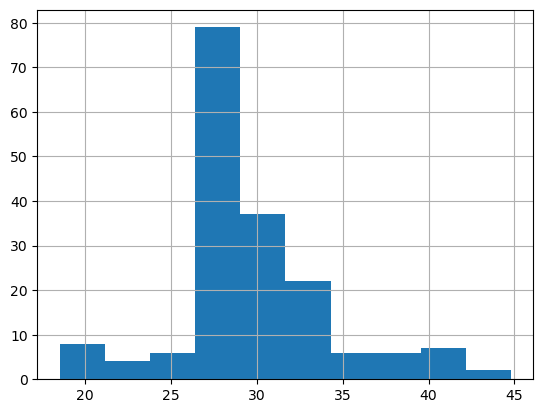

In [ ]:
titanic_data.loc[titanic_data['Age missing'], 'Age'] = rf_age.predict(input_age.values)
titanic_data.loc[titanic_data['Age missing'], 'Age'].hist()

In [ ]:
titanic_data.loc[titanic_data['Age missing'], 'Age'].describe()

count    177.000000
mean      29.762513
std        4.615302
min       18.541527
25%       28.166623
50%       28.861405
75%       31.565804
max       44.798927
Name: Age, dtype: float64

In [ ]:
X = titanic_data[selected_features].values
y = titanic_data['Survived'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7
)

In [ ]:
final_model.fit(X_train, y_train)
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_test_pred))

Train accuracy 0.8834269662921348
Test accuracy 0.776536312849162


In [ ]:
feat_imp_df = pd.DataFrame({
    'Feature name': selected_features,
    'Importance': final_model.feature_importances_
})
feat_imp_df.sort_values('Importance', ascending=False)

,Feature name,Importance
5,SexEn,0.455317
3,Fare,0.165898
9,Age,0.139081
0,Pclass,0.107634
1,SibSp,0.055957
2,Parch,0.027186
6,C,0.018273
8,S,0.016273
4,Age missing,0.008116
7,Q,0.006264


The accuracy improved a litte

### <a id='toc1_7_3_'></a>[Classify by age](#toc0_)

In [ ]:
rf_age_clas = RandomForestClassifier()

In [ ]:
X_train_age_clas, X_test_age_clas, y_train_age_clas, y_test_age_clas = \
    train_test_split(
        titanic_data_age[selected_features_age].values, titanic_data_age['AgeGroupEn'].values,
        test_size=0.2, random_state=7
)

In [ ]:
cv_rf_impute_clas = GridSearchCV(rf_age_clas, param_grid=rf_age_params, scoring='accuracy', refit=True,
                            n_jobs=-1, cv=4, verbose=2, error_score=np.nan, return_train_score=True)

In [ ]:
cv_rf_impute_clas.fit(X_train_age_clas, y_train_age_clas)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 10)}, return_train_score=True,
             scoring='accuracy', verbose=2)

In [ ]:
lr_age_clas = cv_rf_impute_clas.best_estimator_
lr_age_clas

RandomForestClassifier(max_depth=5)

In [ ]:
lr_age_clas.fit(X_train_age_clas, y_train_age_clas)

RandomForestClassifier(max_depth=5)

In [ ]:
y_age_clas_pred = lr_age_clas.predict(X_test_age_clas)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_age_clas, y_age_clas_pred)

0.5754189944134078

In [ ]:
titanic_data['AgeGroupEn'].value_counts() / titanic_data['AgeGroupEn'].value_counts().sum()

2    0.502806
3    0.341190
1    0.066218
0    0.060606
4    0.029181
Name: AgeGroupEn, dtype: float64


## <a id='toc1_8_'></a>[Submission](#toc0_)

In [ ]:
model = final_model

In [ ]:
# train with all data
model.fit(X, y)


RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=6,
                       n_estimators=1000, random_state=7)

In [ ]:
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [ ]:
# missing values, this can have a better treatment
test_data.loc[test_data['Fare'].isna(), 'Fare'] = test_data['Fare'].mean()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [ ]:
test_data = data_engenerring(test_data)
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age missing,SexEn,C,Q,S,AgeGroup,AgeGroupEn
0,892,3,"Kelly, Mr. James",male,34.50000,0,0,330911,7.8292,NaN,Q,False,0,0,1,0,Adult,3
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00000,1,0,363272,7.0000,NaN,S,False,1,0,0,1,Adult,3
2,894,2,"Myles, Mr. Thomas Francis",male,62.00000,0,0,240276,9.6875,NaN,Q,False,0,0,1,0,Elder,4
3,895,3,"Wirz, Mr. Albert",male,27.00000,0,0,315154,8.6625,NaN,S,False,0,0,0,1,Young,2
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00000,1,1,3101298,12.2875,NaN,S,False,1,0,0,1,Young,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,30.27259,0,0,A.5. 3236,8.0500,NaN,S,True,0,0,0,1,Adult,3
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00000,0,0,PC 17758,108.9000,C105,C,False,1,1,0,0,Adult,3
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,False,0,0,0,1,Adult,3
416,1308,3,"Ware, Mr. Frederick",male,30.27259,0,0,359309,8.0500,NaN,S,True,0,0,0,1,Adult,3


In [ ]:
input_age_test = test_data.loc[test_data['Age missing'], selected_features_age]
test_data.loc[test_data['Age missing'], 'Age'] = rf_age.predict(input_age_test.values)
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age missing,SexEn,C,Q,S,AgeGroup,AgeGroupEn
0,892,3,"Kelly, Mr. James",male,34.500000,0,0,330911,7.8292,NaN,Q,False,0,0,1,0,Adult,3
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,363272,7.0000,NaN,S,False,1,0,0,1,Adult,3
2,894,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,240276,9.6875,NaN,Q,False,0,0,1,0,Elder,4
3,895,3,"Wirz, Mr. Albert",male,27.000000,0,0,315154,8.6625,NaN,S,False,0,0,0,1,Young,2
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,3101298,12.2875,NaN,S,False,1,0,0,1,Young,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,28.417149,0,0,A.5. 3236,8.0500,NaN,S,True,0,0,0,1,Adult,3
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C,False,1,1,0,0,Adult,3
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,False,0,0,0,1,Adult,3
416,1308,3,"Ware, Mr. Frederick",male,28.417149,0,0,359309,8.0500,NaN,S,True,0,0,0,1,Adult,3


In [ ]:
test_data_input = test_data[selected_features]
test_data_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       418 non-null    int64  
 1   SibSp        418 non-null    int64  
 2   Parch        418 non-null    int64  
 3   Fare         418 non-null    float64
 4   Age missing  418 non-null    bool   
 5   SexEn        418 non-null    int64  
 6   C            418 non-null    uint8  
 7   Q            418 non-null    uint8  
 8   S            418 non-null    uint8  
 9   Age          418 non-null    float64
dtypes: bool(1), float64(2), int64(4), uint8(3)
memory usage: 21.4 KB


In [ ]:
test_data_pred = model.predict(test_data_input.values)
test_data_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
test_output = test_data[['PassengerId']].copy()
test_output

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [ ]:
test_output['Survived'] = test_data_pred
test_output = test_output.set_index('PassengerId')
test_output

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [ ]:
test_output.to_csv('submission.csv')